## Análise: identificando pontos de melhoria no modelo
Tentando descobrir onde o modelo possui mais incerteza para identificar padrões de Churn.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from Utils.DataTransformer import DataTransformer
from Utils.DuckDb.DuckDb import DuckDb
from Utils.DatasetProcessor.DatasetProcessorUtils import DatasetProcessorUtils
from Utils.DataAnalysis import DataAnalysis
from Utils import PandasNotebookConfigs
import project_config
import matplotlib.pyplot as plt
from Utils.Datetime import DatetimeUtils
from Utils.Dict import DictUtils
from Utils.Number import NumberUtils
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import math

In [ ]:
PandasNotebookConfigs.config()

In [ ]:
DUCK_DB = DuckDb()
DATA_TRANSFORMER = DataTransformer()
DATA_PROCESSOR_UTILS = DatasetProcessorUtils(DUCK_DB)
DATETIME_UTILS = DatetimeUtils()
DICT_UTILS = DictUtils()
DATA_ANALYSIS = DataAnalysis()
NUMBER_UTILS = NumberUtils()

In [ ]:
df = DUCK_DB.load_table(
    project_config.PREDICTED_DATA_TABLE
)

In [ ]:
df

In [ ]:
# Test filtering
# df = df[df['no_churn_information'] == False]
# df = df[:200_000]

In [ ]:
df['uncertainty'] = df.apply(
    lambda row: min(row['predicted_is_churn_proba_true'], row['predicted_is_churn_proba_false']),
    axis=1
)

features = df[['predicted_is_churn_proba_true', 'uncertainty']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [ ]:
# from datetime import datetime
# from sklearn.metrics import silhouette_score

# # Find the optimal cluster qty
# elbow_scores = []
# sil_scores = []
# cluster_range = range(2, 5)  # Testa de 2 até 4 clusters

# for k in cluster_range:
#     print(f'{datetime.now()} Testando {k} clusters...')
#     kmeans = KMeans(n_clusters=k, random_state=42)

#     print(f'{datetime.now()} Fit')
#     kmeans.fit(scaled_features)

#     print(f'{datetime.now()} Elbow')
#     elbow_scores.append(kmeans.inertia_)
    
#     print(f'{datetime.now()} Silhueta')
#     sil = silhouette_score(scaled_features, kmeans.labels_)
#     sil_scores.append(sil)
    
# plt.figure(figsize=(12,5))

# plt.subplot(1,2,1)
# plt.plot(cluster_range, elbow_scores, marker='o')
# plt.title('Elbow Method')
# plt.xlabel('Número de Clusters')
# plt.ylabel('Inércia (Soma dos quadrados intra-cluster)')

# plt.subplot(1,2,2)
# plt.plot(cluster_range, sil_scores, marker='o', color='orange')
# plt.title('Silhouette Score')
# plt.xlabel('Número de Clusters')
# plt.ylabel('Silhouette Score')

# plt.tight_layout()
# plt.show()

In [ ]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_features)

cluster_summary = df.groupby('cluster')[['predicted_is_churn_proba_true', 'uncertainty']].mean()
print("\nResumo dos clusters:")
print(cluster_summary)

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x='predicted_is_churn_proba_true',
    y='uncertainty',
    hue='cluster',
    palette='viridis',
    s=100,
    alpha=0.7
)
plt.title("Clusters: Probabilidade de Churn vs. Incerteza")
plt.xlabel("Probabilidade Predita para Churn (True)")
plt.ylabel("Incerteza (min(prob_true, prob_false))")
plt.show()

# Exibindo a contagem de clientes em cada cluster
cluster_counts = df['cluster'].value_counts()
print("\nContagem de clientes por cluster:")
print(cluster_counts)

In [ ]:
features_to_analyze = [
    'is_auto_renew', 'is_cancel', 'remaining_days',

    # Historical Data
    'num_100', 'num_100-1M', 'num_100-2M',
    'num_25', 'num_25-1M', 'num_25-2M',
    'num_50', 'num_50-1M', 'num_50-2M',
    'num_75', 'num_75-1M', 'num_75-2M',
    'num_985', 'num_985-1M', 'num_985-2M',
    'num_unq', 'num_unq-1M', 'num_unq-2M',
    'total_secs', 'total_secs-1M', 'total_secs-2M',

    # Categorical Data
    'city_0', 'city_1', 'city_10', 'city_11', 'city_12', 'city_13', 'city_14', 'city_15', 'city_16', 'city_17', 'city_18', 'city_19', 'city_2', 'city_20', 'city_21', 'city_22', 'city_3', 'city_4', 'city_5', 'city_6', 'city_7', 'city_8', 'city_9',

    'registered_via_0', 'registered_via_1', 'registered_via_10', 'registered_via_11', 'registered_via_12', 'registered_via_13', 'registered_via_14', 'registered_via_15', 'registered_via_16', 'registered_via_17', 'registered_via_18', 'registered_via_19', 'registered_via_2', 'registered_via_3', 'registered_via_4', 'registered_via_5', 'registered_via_6', 'registered_via_7', 'registered_via_8', 'registered_via_9',

    'payment_method_id_0', 'payment_method_id_1', 'payment_method_id_10', 'payment_method_id_11', 'payment_method_id_12', 'payment_method_id_13', 'payment_method_id_14', 'payment_method_id_15', 'payment_method_id_16', 'payment_method_id_17', 'payment_method_id_18', 'payment_method_id_19', 'payment_method_id_2', 'payment_method_id_20', 'payment_method_id_21', 'payment_method_id_22', 'payment_method_id_23', 'payment_method_id_24', 'payment_method_id_25', 'payment_method_id_26', 'payment_method_id_27', 'payment_method_id_28', 'payment_method_id_29', 'payment_method_id_3', 'payment_method_id_30', 'payment_method_id_31', 'payment_method_id_32', 'payment_method_id_33', 'payment_method_id_34', 'payment_method_id_35', 'payment_method_id_36', 'payment_method_id_37', 'payment_method_id_38', 'payment_method_id_39', 'payment_method_id_4', 'payment_method_id_40', 'payment_method_id_41', 'payment_method_id_5', 'payment_method_id_6', 'payment_method_id_7', 'payment_method_id_8', 'payment_method_id_9',
]

In [ ]:
cluster_uncertainty = df.groupby('cluster')['uncertainty'].mean().sort_values(ascending=False)
uncertain_cluster = cluster_uncertainty.index[0]
print(f"Cluster com maior incerteza: {uncertain_cluster}")

df_uncertain = df[df['cluster'] == uncertain_cluster]
df_rest = df[df['cluster'] != uncertain_cluster]


Correlação entre as features e 'uncertainty':


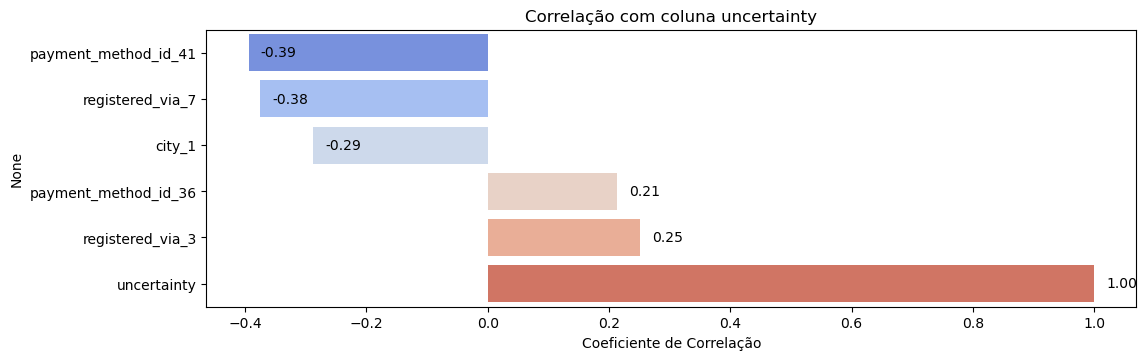

In [65]:
# Filter only valid features to plot graphics
features_to_analyze_filtered = [
    f for f in features_to_analyze if df_uncertain[f].var() != 0 and df_rest[f].var() != 0
]

desc_uncertain = df_uncertain[features_to_analyze].describe()
desc_rest = df_rest[features_to_analyze].describe()

corr_features = features_to_analyze_filtered + ['uncertainty']
corr_matrix = df[corr_features].corr()['uncertainty']

print("\nCorrelação entre as features e 'uncertainty':")

corr_matrix = corr_matrix.loc[(abs(corr_matrix) >= 0.2)]

sorted_corr_matrix = corr_matrix.sort_values()

plt.figure(figsize=(12, 0.6 * len(sorted_corr_matrix)))

ax = sns.barplot(
    x=sorted_corr_matrix.values,
    y=sorted_corr_matrix.index,
    hue=sorted_corr_matrix.index,
    legend=False,
    palette='coolwarm'
)

# Add the correlation values next to the bars
for i, value in enumerate(sorted_corr_matrix.values):
    ax.text(value + 0.02, i, f"{value:.2f}", color='black', va='center')  # Adjust text position slightly

# Final touches to the plot
plt.title("Correlação com coluna uncertainty")
plt.xlabel("Coeficiente de Correlação")
plt.show()

In [69]:
print(
    f'Qtd. de dados do cluster de incerteza: {NUMBER_UTILS.format_integer_number(len(df_uncertain))}\n'
    f'Qtd. de dados dos outro cluster: {NUMBER_UTILS.format_integer_number(len(df_rest))}'
)

Qtd. de dados do cluster de incerteza: 493.569
Qtd. de dados dos outro cluster: 757.501


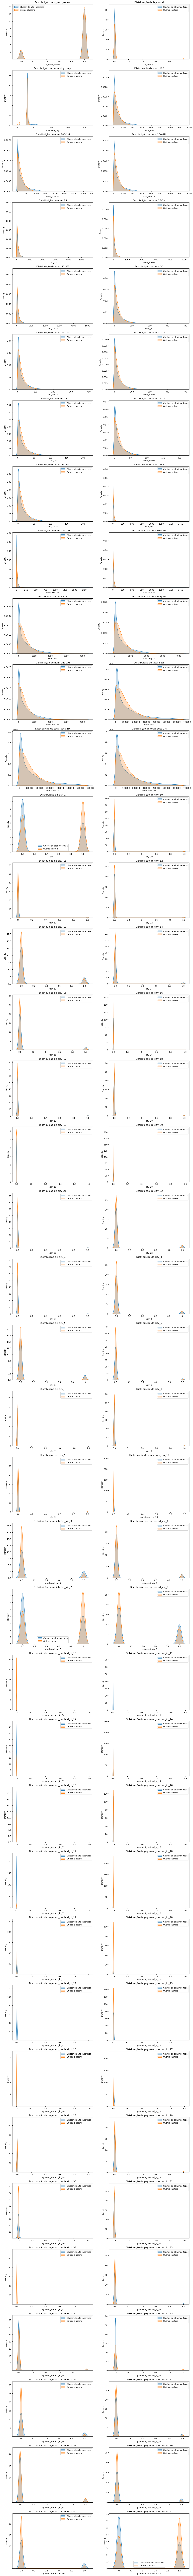

In [66]:
fig, axs = plt.subplots(
    math.ceil(len(features_to_analyze_filtered) / 2), 2,
    figsize=(16, len(features_to_analyze_filtered) * 3)
)

axs = axs.flatten()

for index, feature in enumerate(features_to_analyze_filtered):
    sns.kdeplot(
        df_uncertain[feature],
        label='Cluster de alta incerteza',
        fill=True,
        warn_singular=False,
        ax=axs[index]
    )

    sns.kdeplot(
        df_rest[feature],
        label='Outros clusters',
        fill=True,
        warn_singular=False,
        ax=axs[index]
    )

    axs[index].set_title(f'Distribuição de {feature}')
    axs[index].set_label(feature)
    axs[index].legend()

plt.show()